# SHHS dataset exploration and EDF converstion

In [1]:
"""
From https://physionet.org/content/shhpsgdb/1.0.0/

"""
import wfdb
import os
import pyedflib
import numpy as np

In [2]:
ROOT = "D:\data\sleep-heart-health-study-psg-database-1.0.0"

### Exploration of signals and annotation using WFDB

In [3]:
record = None

annotation1 = None
annotation2 = None
annotation3 = None
annotation_list = None

with open(ROOT + "\RECORDS", "r") as f:

    for file in f:
        print(file)
        _full_path = os.path.join(ROOT, file).rstrip()
        print(_full_path)
        record = wfdb.rdrecord(_full_path)
        print(record)
        
        # Hypnogram annotations 30-sec epoch 
        annotation1 = wfdb.rdann(_full_path, "hypn")
        
        # arousal annotations Duration in minutes, seconds, and tenths of seconds (m:ss.s)
        annotation2 = wfdb.rdann(_full_path, "arou")
                
        # Oximeter artifact Duration in minutes, seconds, and tenths of seconds (m:ss.s)
        annotation3 = wfdb.rdann(_full_path, "oart")
        
        # Respiratory event (Hyp: hypopnea; Ob.A: obstructive apnea; Cn.A: central apnea)
        # Duration in minutes, seconds, and tenths of seconds (m:ss.s)
        # Percent decrease in SaO2 associated with the event
        # Minimum SaO2 (percent) associated with the event
        annotation4 = wfdb.rdann(_full_path, "resp")
        
        # composite annotation of all other annotations SKIPPED
        annotation5 = wfdb.rdann(_full_path, "comp")
        
        
        
        annotation_list = [annotation1, annotation2, annotation3, annotation4]
        
        for annotation in annotation_list:
            
            print("{} \t \t{} \t \t {}".format(annotation.extension, annotation.aux_note, annotation.sample))

            print("\n", "-"*80, "\n")
        

        print(record.__dict__)
        


0000

D:\data\sleep-heart-health-study-psg-database-1.0.0\0000
hypn 	 	['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', '1', '2', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', '2', 'W', 'W', 'W', 'W', 'W', 'W', 'W', '1', '1', '1', 'W', 'W', 'W', 'W', 'W', 'W', '1', '2', '2', '2', '2', '2', '2', '2', '2', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', '1', '1', '2', '2', '2', '2', '2', '2', '3', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '2', '3', '2', '3', '3', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3'

In [4]:
"""The sizes of these annotations did not match the record, which gave errors for the plotting"""

annotation1.sample[-1] = annotation1.sample[-1] -2
annotation3.sample[-1] = annotation3.sample[-1] -2

In [5]:
if False:
    for i in list(range(5)):
      
        wfdb.plot_wfdb(record=record, annotation=annotation_list[i], plot_sym=True,
           time_units='seconds', title=annotation_list[i].extension,
           figsize=(10,4))

In [6]:
if False:
    for i in list(range(5)):
    
        wfdb.plot_wfdb(annotation=annotation_list[i], plot_sym=True,
           time_units='seconds', title=annotation_list[i].extension,
           figsize=(10,4))

#### Creating Marco's dictionary for signal and annotation

I want to try to make a single dictionary per subject containing all signals and annotations. Then I will convert that into a single EDF file. 

In [7]:
def create_signal_from_SHHS_anotation(annotation, signal_length, SAMPLE_RATE):
    signal = np.zeros(signal_length)
    
    start_index = 0
    stop_index = 0
    if annotation.extension == "hypn":
                
        for i, note in enumerate(annotation.aux_note):
            
            
            annotation_value = sleep_staging_to_index(note)
            
            stop_index = annotation.sample[i]
            
            signal[start_index:stop_index] = annotation_value
            
            start_index = stop_index
            
        return signal
    
    elif annotation.extension == "arou" or annotation.extension == "oart" or annotation.extension == "resp":

        for i, note in enumerate(annotation.aux_note):
            
            start_index = annotation.sample[i]
            stop_index = int(start_index + aux_note_to_length(note, SAMPLE_RATE))
            
            signal[start_index:stop_index] = 1
            
        return signal
      
    elif annotation.extension == "comp":
        print("Composite annotation not supported")
        return None
    else:
        print("EXTENSION NOT FOUND")
        raise NameError
        
def sleep_staging_to_index(aux_note):
    if aux_note == "W":
        return 1
    elif aux_note == "R":
        return 0
    elif aux_note == "1":
        return -1
    elif aux_note == "2":
        return -2
    elif aux_note == "3":
        return -3
    else:
        return 8
    
def aux_note_to_length(aux_note, SAMPLE_RATE):
    # I need to convert from Duration in minutes, seconds, and tenths of seconds (m:ss.s)
    # Into actual values, so I need to know the sampling frequency
    
    aux_note = aux_note.replace('Arousal ', '')
    
    # TODO should I use the % values associated with resp events?
    aux_note = aux_note.replace('SaO2.Art ', '')
    
    # TODO should I give different values for these 3 events?
    aux_note = aux_note.replace('Hyp ', '')
    aux_note = aux_note.replace('Cn.A ', '')
    aux_note = aux_note.replace('Ob.A ', '')
    
    aux_note = aux_note.replace('.', ':')
    aux_note = aux_note.replace(' ', ':')

    aux_note = aux_note.split(":")
    
    seconds = 0.0
    # add minutes
    seconds += int(aux_note[0])*60
    
    # add seconds
    seconds += int(aux_note[1])
    
    # add tenth of seconds
    seconds += int(aux_note[2])*0.1
    
    return seconds * SAMPLE_RATE



In [8]:
def subject_to_edf(record, annotation_list):
    
    print("Creating subject {} EDF file: {} \n".format(record.record_name, record.comments))
     
    
    # sample rate is constant since the p_signal arrays are of the same size
    # TODO what is the actual sample rate?
    SAMPLE_RATE = 1
    signal_length = record.sig_len
    
    channel_info = []
    data_list = []
    
    # Creating the data signals from various recordings
    for i in list(range(record.n_sig)):
        
        # What do these values mean exactly? adc_zero, adz_gain, baseline, checksum, init_value
        
        ch_dict = {'label': record.sig_name[i], 'dimension': record.units[i], 
                   'sample_rate': SAMPLE_RATE, 'physical_max': 100, 'physical_min': -100, 
                   'digital_max': 32767, 'digital_min': -32768, 'transducer': '', 'prefilter':''}
        
        channel_info.append(ch_dict)
        
        data_list.append(record.p_signal[:, i])

    # Creating the annotation signals
    for i, annotation in enumerate(annotation_list):
                
        ch_dict = {'label': annotation.extension, 'dimension': "hand_annotation", 
           'sample_rate': SAMPLE_RATE, 'physical_max': 100, 'physical_min': -100, 
           'digital_max': 32768, 'digital_min': -32768, 'transducer': '', 'prefilter':''}
        
        channel_info.append(ch_dict)
        
        signal = create_signal_from_SHHS_anotation(annotation, signal_length, SAMPLE_RATE)
        
        data_list.append(signal)
    
    
    test_data_file = os.path.join('.', 'test_generato0.edf')

    f = pyedflib.EdfWriter(test_data_file, len(channel_info),
                           file_type=pyedflib.FILETYPE_EDFPLUS)
    
    print(channel_info)
    print(data_list)
    f.setSignalHeaders(channel_info)
    f.writeSamples(data_list)
    f.close()
    
    del f
    
    return data_list


data_list = subject_to_edf(record, annotation_list)



Creating subject 0000 EDF file: ['<age>: 47  <sex>: F  <BMI>: 29.73215'] 

[{'label': 'SaO2', 'dimension': '%', 'sample_rate': 1, 'physical_max': 100, 'physical_min': -100, 'digital_max': 32767, 'digital_min': -32768, 'transducer': '', 'prefilter': ''}, {'label': 'PR', 'dimension': 'BPM', 'sample_rate': 1, 'physical_max': 100, 'physical_min': -100, 'digital_max': 32767, 'digital_min': -32768, 'transducer': '', 'prefilter': ''}, {'label': 'EEG(sec)', 'dimension': 'uV', 'sample_rate': 1, 'physical_max': 100, 'physical_min': -100, 'digital_max': 32767, 'digital_min': -32768, 'transducer': '', 'prefilter': ''}, {'label': 'ECG', 'dimension': 'mV', 'sample_rate': 1, 'physical_max': 100, 'physical_min': -100, 'digital_max': 32767, 'digital_min': -32768, 'transducer': '', 'prefilter': ''}, {'label': 'EMG', 'dimension': 'uV', 'sample_rate': 1, 'physical_max': 100, 'physical_min': -100, 'digital_max': 32767, 'digital_min': -32768, 'transducer': '', 'prefilter': ''}, {'label': 'EOG(L)', 'dimensio

In [147]:
test = 'Hyp 0:10.8 2 94'

test = test.strip('Arousal ')
test = test.strip('SaO2.Art ')
test = test.strip('Hyp ')
test = test.strip('Ob.A ')
test = test.replace('.', ':')
test = test.replace(' ', ':')

test = test.split(":")
print(test)
print(int(test[0]), int(test[1]), int(test[2]))

aux_note_to_length('Hyp 0:10.8 2 94', 1)



['0', '10', '8', '2', '94']
0 10 8


10.8

Text(0.5, 1.0, 'resp')

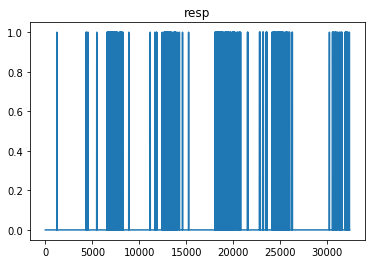

In [212]:
to_plot = annotation_list[3]

plt.plot(create_signal_from_SHHS_anotation(to_plot, record.sig_len, 1))
plt.title(to_plot.extension)

In [12]:
print(record.__dict__.keys())

dict_keys(['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'])


{'record_name': '0000', 'extension': 'resp', 'sample': array([ 1227,  4328,  4392,  4538,  5466,  6568,  6590,  6617,  6673,
        6707,  6732,  6753,  6784,  6809,  6840,  6917,  6964,  6986,
        7012,  7078,  7111,  7143,  7180,  7229,  7283,  7337,  7370,
        7387,  7457,  7477,  7529,  7569,  7616,  7642,  7725,  7900,
        7931,  7968,  7992,  8029,  8075,  8103,  8140,  8206,  8278,
        8878, 11153, 11661, 11821, 11858, 12438, 12608, 12659, 12687,
       12717, 12751, 12792, 12833, 12871, 12948, 12970, 13010, 13058,
       13111, 13176, 13199, 13215, 13282, 13314, 13374, 13445, 13555,
       13675, 13709, 13752, 13782, 13820, 13865, 13922, 14076, 14263,
       14595, 15243, 18041, 18091, 18140, 18171, 18209, 18235, 18269,
       18290, 18329, 18361, 18386, 18413, 18453, 18478, 18519, 18553,
       18587, 18648, 18672, 18711, 18740, 18816, 18849, 18895, 18936,
       19026, 19105, 19145, 19182, 19208, 19265, 19303, 19334, 19385,
       19414, 19454, 19478, 19521, 

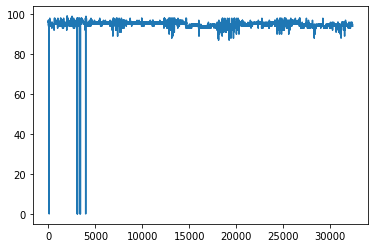

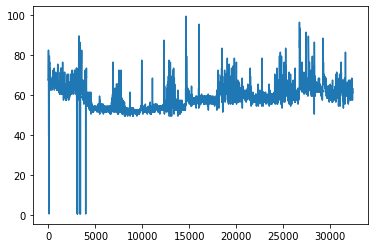

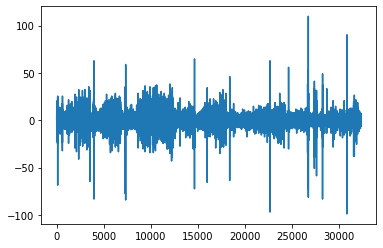

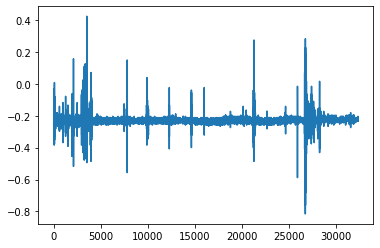

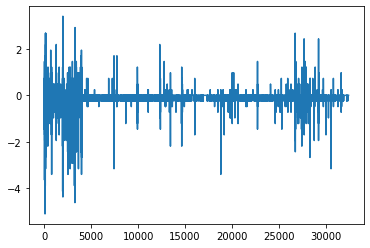

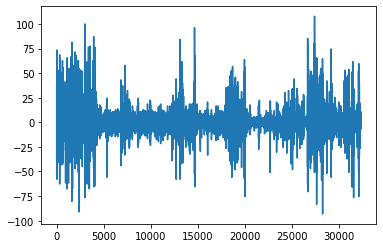

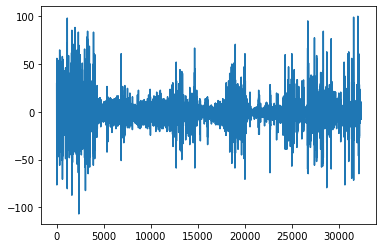

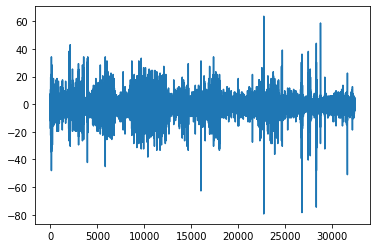

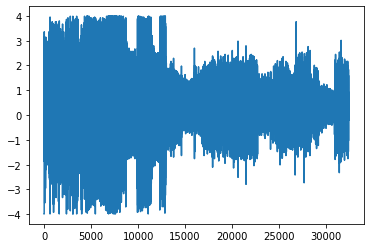

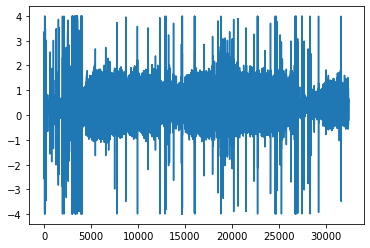

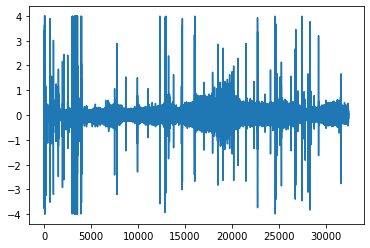

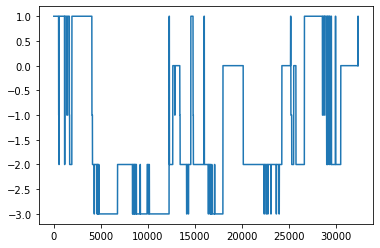

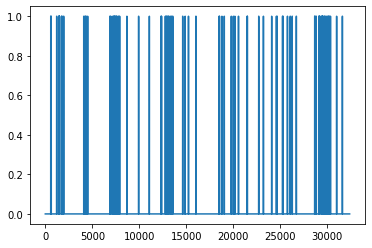

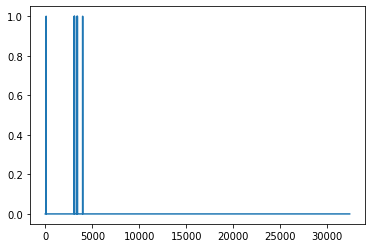

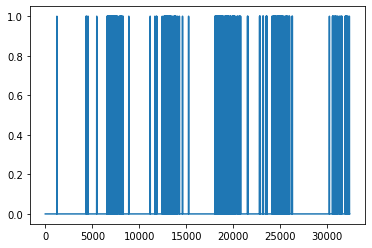

In [210]:
print(annotation_list[3].__dict__)

for item in data_list:
    plt.plot(item)
    plt.show()

other

In [17]:
ROOT = 'C:\\Users\\320086129\\PycharmProjects\\thesis_2019_2020\\Physionet_project\\testing.edf'

In [21]:
with open(ROOT, 'rb') as f:
    for row in f:
        print(row)
        print(asd)

b'0       0000                                                                                                                                                            05.29.0121.30.003072                                                -1      1       11  SaO2            PR              EEG(sec)        ECG             EMG             EOG(L)          EOG(R)          EEG             AIRFLOW         THOR RES        ABDO RES        Unknown                                                                         Unknown                                                                         Unknown                                                                         Unknown                                                                         Unknown                                                                         Unknown                                                                         Unknown                                                                         Unknow

NameError: name 'asd' is not defined

# SHHS from sleepdata.org

In [55]:
arousal_xml_path = 'D:\data\SHHS\\shhs1-200001-nsrr.xml'

In [56]:
import xml.etree.ElementTree as ET
tree = ET.parse(arousal_xml_path)
root = tree.getroot()

In [57]:
for child in root:
    print(child.tag, child.attrib)

SoftwareVersion {}
EpochLength {}
ScoredEvents {}


In [58]:
events = list(root)[-1]

for child in events:
    print(child[0].tag, child[0].text, child[1].tag, child[1].text, child[2].tag, child[2].text, child[3].tag, child[3].text)

EventType None EventConcept Recording Start Time Start 0 Duration 32520.0
EventType Respiratory|Respiratory EventConcept SpO2 artifact|SpO2 artifact Start 304 Duration 3
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 964.8 Duration 25.4
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 1552.2 Duration 23
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 1595.2 Duration 9.7
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 1627.9 Duration 4.9
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 1751 Duration 10.8
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 1883.6 Duration 19
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 2066.1 Duration 11.4
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 2488.9 Duration 5.7
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 2628.3 Duration 11.9
EventType Arousals|Arousals EventConcept Arousal|Arousal 

EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 20221.8 Duration 7.4
EventType Arousals|Arousals EventConcept Arousal|Arousal () Start 20240.2 Duration 10
EventType Respiratory|Respiratory EventConcept Hypopnea|Hypopnea Start 20684.5 Duration 22.4
EventType Respiratory|Respiratory EventConcept SpO2 desaturation|SpO2 desaturation Start 20714.5 Duration 22.4
EventType Respiratory|Respiratory EventConcept Hypopnea|Hypopnea Start 20732.8 Duration 26.2
EventType Respiratory|Respiratory EventConcept SpO2 desaturation|SpO2 desaturation Start 20762.8 Duration 26.2
EventType Respiratory|Respiratory EventConcept Hypopnea|Hypopnea Start 20773 Duration 12
EventType Respiratory|Respiratory EventConcept Hypopnea|Hypopnea Start 20795.3 Duration 14.2
EventType Respiratory|Respiratory EventConcept SpO2 desaturation|SpO2 desaturation Start 20803 Duration 12
EventType Respiratory|Respiratory EventConcept SpO2 desaturation|SpO2 desaturation Start 20825.3 Duration 14.2
EventType Respirato

EventType Stages|Stages EventConcept Wake|0 Start 4740.0 Duration 30.0
EventType Stages|Stages EventConcept Stage 1 sleep|1 Start 4770.0 Duration 60.0
EventType Stages|Stages EventConcept Wake|0 Start 4830.0 Duration 30.0
EventType Stages|Stages EventConcept Stage 1 sleep|1 Start 4860.0 Duration 30.0
EventType Stages|Stages EventConcept Stage 2 sleep|2 Start 4890.0 Duration 240.0
EventType Stages|Stages EventConcept Wake|0 Start 5130.0 Duration 60.0
EventType Stages|Stages EventConcept Stage 1 sleep|1 Start 5190.0 Duration 60.0
EventType Stages|Stages EventConcept Stage 2 sleep|2 Start 5250.0 Duration 300.0
EventType Stages|Stages EventConcept Wake|0 Start 5550.0 Duration 60.0
EventType Stages|Stages EventConcept Stage 2 sleep|2 Start 5610.0 Duration 180.0
EventType Stages|Stages EventConcept Wake|0 Start 5790.0 Duration 60.0
EventType Stages|Stages EventConcept Stage 1 sleep|1 Start 5850.0 Duration 30.0
EventType Stages|Stages EventConcept Stage 2 sleep|2 Start 5880.0 Duration 300.0
E

In [59]:
import collections

In [60]:
cnt = collections.Counter()

cnt2 = collections.Counter()

for child in events:
    #print(child[0].tag, child[0].text, child[1].tag, child[1].text, child[2].tag, child[2].text, child[3].tag, child[3].text)
    thing = str(child[0].text)
    print(child[0].tag, child[0].text, child[-1].tag, child[-1].text)

    cnt[thing] += 1

    
print(cnt)
print(len(cnt))

EventType None ClockTime 00.00.00 22.00.00
EventType Respiratory|Respiratory SignalLocation SaO2
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Respiratory|Respiratory SignalLocation NEW AIR
EventType Respiratory|Respiratory SpO2Baseline 95.0
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Arousals|Arousals SignalLocation EMG
EventType Respiratory|Respiratory SignalLocation SaO2
EventType Respiratory|Respiratory S

EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 390.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 90.0
EventType Stages|Stages Duration 60.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 180.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 750.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 390.0
EventType Stages|Stages Duration 750.0
EventType Stages|Stages Duration 240.0
EventType Stages|Stages Duration 150.0
EventType Stages|Stages Duration 360.0
EventType Stages|Stages Duration 60.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 90.0
EventType Stages|Stages Duration 90.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 480.0
EventType Stages|Stages Duration 240.0
EventType Stages|Stages Duration 30.0
EventType Stages|Stages Duration 90.0
Ev

In [61]:
"""
Arousal 
Hypopnea 
SpO2_desaturation
SpO2_artifact
Hypnogram (wake, REM, 1,2,3)
Obstructive apnea 

The sampling rate for all of these will be the same. Namely 10 Hz. Since you can have tenth of a second
The full stream of data will be determined by the duration of the recording start time in seconds * 10. e.g. 32520 * 10 
"""
import xml.etree.ElementTree as ET
import numpy as np
import os
import pyedflib

def create_signal_from_SHHS_xml(arousal_xml_path):
    
    sample_rate = 10
    
    tree = ET.parse(arousal_xml_path)
    root = tree.getroot() 
    events = list(root)[-1]
    
    recording_duration = int(float(events[0][3].text) * sample_rate)
    
    #print(recording_duration)
    
    arousal, hypopnea, spO2_desaturation, spO2_artifact, hypnogram, obstructive_apnea = np.zeros(recording_duration) ,np.zeros(recording_duration),np.zeros(recording_duration),np.zeros(recording_duration) ,np.zeros(recording_duration) ,np.zeros(recording_duration)
    
    central_apnea = np.zeros(recording_duration)
    for child in events:
        
        event = str(child[1].text).split("|")[0]
        event_start = int(float(child[2].text) * sample_rate)
        event_duration = int(float(child[3].text) * sample_rate)
        event_end = event_start + event_duration
        
        #print(event)
        if event == "Recording Start Time":
            continue
            
        elif event == "Arousal":
            arousal[event_start:event_end] = 1
        
        elif event == "Hypopnea":
            hypopnea[event_start:event_end] = 1
        
        elif event == "SpO2 desaturation":
            spO2_desaturation[event_start:event_end] = 1
        
        elif event == "SpO2 artifact":
            spO2_artifact[event_start:event_end] = 1
        
        elif event == "Obstructive apnea":
            obstructive_apnea[event_start:event_end] = 1
            
        elif event == "Central apnea":
            central_apnea[event_start:event_end] = 1
        
        elif event == "Wake":
            hypnogram[event_start:event_end] = 1
        
        elif event == "REM sleep":
            hypnogram[event_start:event_end] = 0
        
        elif event == "Stage 1 sleep":
            hypnogram[event_start:event_end] = -1
        
        elif event == "Stage 2 sleep":
            hypnogram[event_start:event_end] = -2
        
        elif event == "Stage 3 sleep":
            hypnogram[event_start:event_end] = -3
            
        elif event == "Stage 4 sleep":
            hypnogram[event_start:event_end] = -4
        
        else:
            print("{} event type not found!".format(event))
        
    
    annotation_names = ['arousal', 'hypopnea', 'spO2_desaturation', 'spO2_artifact', 'hypnogram', 'obstructive_apnea', 'central_apnea']
    annotation_list = [arousal, hypopnea, spO2_desaturation, spO2_artifact, hypnogram, obstructive_apnea, central_apnea]
    
    return annotation_list, annotation_names
    
arousal_xml_path = 'D:\data\SHHS\\shhs1-200004-nsrr.xml'

x, y = create_signal_from_SHHS_xml(arousal_xml_path)

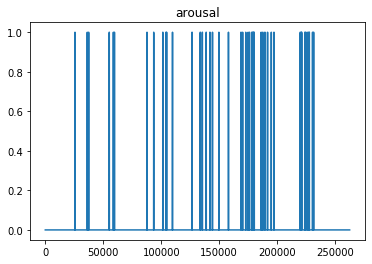

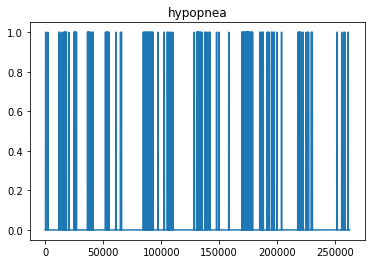

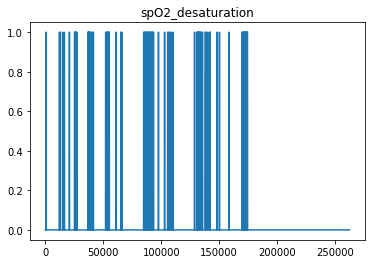

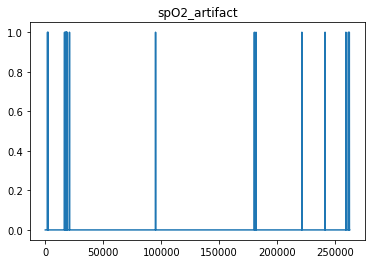

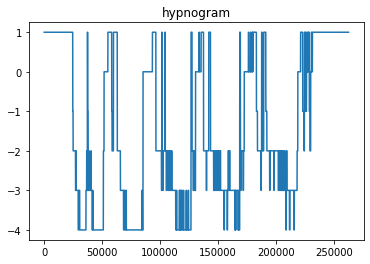

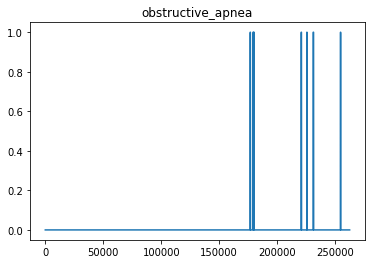

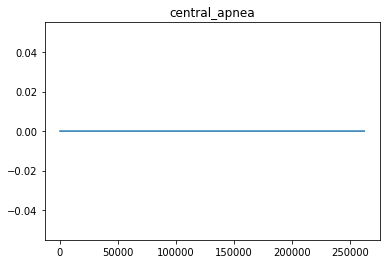

In [62]:
import matplotlib.pyplot as plt

for i, plotty in enumerate(x):

    plt.plot(plotty)
    plt.title(y[i])
    plt.show()

In [63]:
def subject_to_edf(arousal_xml_path):
    
    print("\nCreating subject {}".format(arousal_xml_path.strip("-nsrr.xml")))
    
    channel_info = []
    data_list = []
    
    original_edf = arousal_xml_path.strip("-nsrr.xml") + ".edf"
    
    with pyedflib.EdfReader(original_edf) as f:
    
        for channel in list(range(f.signals_in_file)):

            ch_dict = {'label': f.getLabel(channel), 'dimension': f.getPhysicalDimension(channel), 
               'sample_rate': f.getSampleFrequency(channel), 'physical_max': f.getPhysicalMaximum(channel), 
               'physical_min': f.getPhysicalMinimum(channel), 'digital_max': f.getDigitalMaximum(channel), 
               'digital_min': f.getDigitalMinimum(channel), 'transducer': f.getTransducer(channel), 
               'prefilter': f.getPrefilter(channel)}

            channel_info.append(ch_dict)
            data_list.append(f.readSignal(channel))
     
    # Sample rate for the annotations are always 10
    sample_rate = 10
  
    annotation_list, annotation_names = create_signal_from_SHHS_xml(arousal_xml_path)
    
    # Creating the annotation signals
    for i, annotation in enumerate(annotation_list):
                
        ch_dict = {'label': annotation_names[i], 'dimension': "", 
           'sample_rate': sample_rate, 'physical_max': 100, 'physical_min': -100, 
           'digital_max': 32768, 'digital_min': -32768, 'transducer': '', 'prefilter':''}
        
        channel_info.append(ch_dict)
        
        signal = annotation
        
        data_list.append(signal)
    
    
    name_ = arousal_xml_path.strip('-nsrr.xml')
    name_ += '-combined.edf'
    
    test_data_file = os.path.join('.', name_)

    with pyedflib.EdfWriter(test_data_file, len(channel_info), file_type=pyedflib.FILETYPE_EDFPLUS) as f:
    
        #print(channel_info)
        #print(data_list)
        f.setSignalHeaders(channel_info)
        f.writeSamples(data_list)



arousal_xml_path = 'D:\data\SHHS\\shhs1-200001-nsrr.xml'
subject_to_edf(arousal_xml_path)


Creating subject D:\data\SHHS\shhs1-200001



library version: 0.1.15

general header:

edfsignals: 14
file duration: 32520 seconds
startdate: 1-1-1985
starttime: 22:00:00
patientcode: 
gender: 
birthdate: 
patient_name: 
patient_additional: 
admincode: 
technician: 
equipment: 
recording_additional: 
datarecord duration: 32520.000000 seconds
number of datarecords in the file: 32520
number of annotations in the file: 0

signal parameters for the 0.channel:


label: SaO2
samples in file: 32520
physical maximum: 100.000000
physical minimum: 0.000000
digital maximum: 32767
digital minimum: -32768
physical dimension: 
prefilter: 
transducer: 
samplefrequency: 1.000000

signal parameters for the 1.channel:


label: H.R.
samples in file: 32520
physical maximum: 250.000000
physical minimum: 0.000000
digital maximum: 32767
digital minimum: -32768
physical dimension: 
prefilter: 
transducer: 
samplefrequency: 1.000000

signal parameters for the 2.channel:


label: EEG(sec)
samples in file: 4065000
physical maximum: 125.000000
physical min

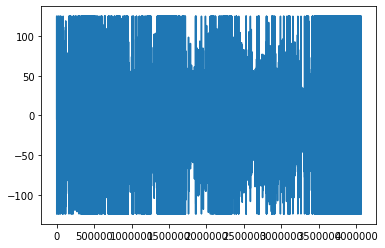

In [64]:
"""
From https://github.com/holgern/pyedflib/blob/master/demo/readEDFFile.py
"""
    
with pyedflib.EdfReader('D:\data\SHHS\\shhs1-200001.edf') as f:
    print("\nlibrary version: %s" % pyedflib.version.version)

    print("\ngeneral header:\n")

    # print("filetype: %i\n"%hdr.filetype);
    print("edfsignals: %i" % f.signals_in_file)
    print("file duration: %i seconds" % f.file_duration)
    print("startdate: %i-%i-%i" % (f.getStartdatetime().day,f.getStartdatetime().month,f.getStartdatetime().year))
    print("starttime: %i:%02i:%02i" % (f.getStartdatetime().hour,f.getStartdatetime().minute,f.getStartdatetime().second))
    # print("patient: %s" % f.getP);
    # print("recording: %s" % f.getPatientAdditional())
    print("patientcode: %s" % f.getPatientCode())
    print("gender: %s" % f.getGender())
    print("birthdate: %s" % f.getBirthdate())
    print("patient_name: %s" % f.getPatientName())
    print("patient_additional: %s" % f.getPatientAdditional())
    print("admincode: %s" % f.getAdmincode())
    print("technician: %s" % f.getTechnician())
    print("equipment: %s" % f.getEquipment())
    print("recording_additional: %s" % f.getRecordingAdditional())
    print("datarecord duration: %f seconds" % f.getFileDuration())
    print("number of datarecords in the file: %i" % f.datarecords_in_file)
    print("number of annotations in the file: %i" % f.annotations_in_file)

    plt.plot(f.readSignal(2))

    for channel in list(range(f.signals_in_file)):
        print("\nsignal parameters for the %d.channel:\n\n" % channel)

        print("label: %s" % f.getLabel(channel))
        print("samples in file: %i" % f.getNSamples()[channel])
        # print("samples in datarecord: %i" % f.get
        print("physical maximum: %f" % f.getPhysicalMaximum(channel))
        print("physical minimum: %f" % f.getPhysicalMinimum(channel))
        print("digital maximum: %i" % f.getDigitalMaximum(channel))
        print("digital minimum: %i" % f.getDigitalMinimum(channel))
        print("physical dimension: %s" % f.getPhysicalDimension(channel))
        print("prefilter: %s" % f.getPrefilter(channel))
        print("transducer: %s" % f.getTransducer(channel))
        print("samplefrequency: %f" % f.getSampleFrequency(channel))


In [65]:
import pandas as pd

patient_records_path = "D:\data\SHHS\shhs1-dataset-0.15.0.csv"

df = pd.read_csv(patient_records_path)

df.head()

for subject_id in df.nsrrid:
    
    id_file_path_ = "shhs1-" + str(subject_id) + "-nsrr.xml"
    id_file_path = os.path.join(os.path.split(patient_records_path)[0], id_file_path_)
    
    if os.path.exists(id_file_path):
        subject_to_edf(id_file_path)
        print("Completed")
    else:
        print("{} does not exist, skipping".format(id_file_path))
        


Creating subject D:\data\SHHS\shhs1-200001
Completed

Creating subject D:\data\SHHS\shhs1-200002
Completed

Creating subject D:\data\SHHS\shhs1-200003
Completed

Creating subject D:\data\SHHS\shhs1-200004
Completed

Creating subject D:\data\SHHS\shhs1-200005
Completed

Creating subject D:\data\SHHS\shhs1-200006
Completed

Creating subject D:\data\SHHS\shhs1-200007
Completed

Creating subject D:\data\SHHS\shhs1-200008
Completed

Creating subject D:\data\SHHS\shhs1-200009
Completed

Creating subject D:\data\SHHS\shhs1-200010
Completed

Creating subject D:\data\SHHS\shhs1-200011
Completed

Creating subject D:\data\SHHS\shhs1-200012
Completed

Creating subject D:\data\SHHS\shhs1-200013
Completed

Creating subject D:\data\SHHS\shhs1-200014
Completed

Creating subject D:\data\SHHS\shhs1-200015
Completed

Creating subject D:\data\SHHS\shhs1-200016
Completed

Creating subject D:\data\SHHS\shhs1-200017
Completed

Creating subject D:\data\SHHS\shhs1-200018
Completed

Creating subject D:\data\SH

D:\data\SHHS\shhs1-200415-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200416-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200417-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200418-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200419-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200420-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200421-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200422-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200423-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200424-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200425-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200426-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200427-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200428-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200429-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200430-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200431-nsrr.xml does 

D:\data\SHHS\shhs1-200848-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200849-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200850-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200851-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200852-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200853-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200854-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200855-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200856-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200857-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200858-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200859-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200860-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200861-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200862-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200863-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-200864-nsrr.xml does 

D:\data\SHHS\shhs1-201302-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201303-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201304-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201305-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201306-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201307-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201308-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201309-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201310-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201311-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201312-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201313-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201314-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201315-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201316-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201317-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201318-nsrr.xml does 

D:\data\SHHS\shhs1-201630-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201631-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201632-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201633-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201634-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201635-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201636-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201637-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201638-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201639-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201640-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201641-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201642-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201643-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201644-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201645-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-201646-nsrr.xml does 

D:\data\SHHS\shhs1-202109-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202110-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202111-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202112-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202113-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202114-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202115-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202116-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202117-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202118-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202119-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202120-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202121-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202122-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202123-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202124-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202125-nsrr.xml does 

D:\data\SHHS\shhs1-202520-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202521-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202522-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202523-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202524-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202525-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202526-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202527-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202528-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202529-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202530-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202531-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202532-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202533-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202534-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202535-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202536-nsrr.xml does 

D:\data\SHHS\shhs1-202978-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202979-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202980-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202981-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202982-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202983-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202984-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202985-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202986-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202987-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202988-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202989-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202990-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202991-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202992-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202993-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-202994-nsrr.xml does 

D:\data\SHHS\shhs1-203403-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203404-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203405-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203406-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203407-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203408-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203409-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203410-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203411-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203412-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203413-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203414-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203415-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203416-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203417-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203418-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203419-nsrr.xml does 

D:\data\SHHS\shhs1-203820-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203821-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203822-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203823-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203824-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203825-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203826-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203827-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203828-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203829-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203830-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203831-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203832-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203833-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203834-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203835-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-203836-nsrr.xml does 

D:\data\SHHS\shhs1-204323-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204324-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204325-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204326-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204327-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204328-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204329-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204330-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204331-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204332-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204333-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204334-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204335-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204336-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204337-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204338-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204339-nsrr.xml does 

D:\data\SHHS\shhs1-204793-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204794-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204795-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204796-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204797-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204798-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204799-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204800-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204801-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204802-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204803-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204804-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204805-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204806-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204807-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204808-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-204809-nsrr.xml does 

D:\data\SHHS\shhs1-205277-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205278-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205279-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205280-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205281-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205282-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205283-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205284-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205285-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205286-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205287-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205288-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205289-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205290-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205291-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205292-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205293-nsrr.xml does 

D:\data\SHHS\shhs1-205760-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205761-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205762-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205763-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205764-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205765-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205766-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205767-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205768-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205769-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205770-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205771-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205772-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205773-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205774-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205775-nsrr.xml does not exist, skipping
D:\data\SHHS\shhs1-205776-nsrr.xml does 